In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [16]:
df=pd.read_csv("132_Temp.csv")

In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [18]:
df.dropna(inplace=True)

In [19]:
df.head()

,Temperature,Humidity,Outside Temperature,Previous Date,Temperature on Previous day,2 days before Date,Temperature 2 days before
Date,,,,,,,
2020-01-15 01:44:00,70.7,64.75,68,1/14/2020 1:44,69.8,1/13/2020 1:44,68.1
2020-01-15 03:44:00,70.6,66.51,66,1/14/2020 3:44,69.8,1/13/2020 3:44,68.0
2020-01-15 05:44:00,70.6,67.79,68,1/14/2020 5:44,69.7,1/13/2020 5:44,67.8
2020-01-15 07:44:00,69.8,60.85,72,1/14/2020 7:44,71.8,1/13/2020 7:44,66.7
2020-01-15 09:44:00,70.6,57.82,75,1/14/2020 9:44,72.5,1/13/2020 9:44,68.6


In [20]:
ts=df.loc['1/15/2020':'2/15/2020']['Temperature']
#ts=pd.DataFrame(ts)
ts.head()

Date
2020-01-15 01:44:00    70.7
2020-01-15 03:44:00    70.6
2020-01-15 05:44:00    70.6
2020-01-15 07:44:00    69.8
2020-01-15 09:44:00    70.6
Name: Temperature, dtype: float64

In [21]:
ts.shape

(384,)

# 1st approach

In [22]:
# Create Training and Test
train = ts[:288]
test = ts[288:]

In [23]:
#building the model
import pmdarima as pm
from pmdarima.arima import auto_arima

In [164]:
model = pm.auto_arima(train, start_p=1, start_q=1, seasonal=True, m=12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as s

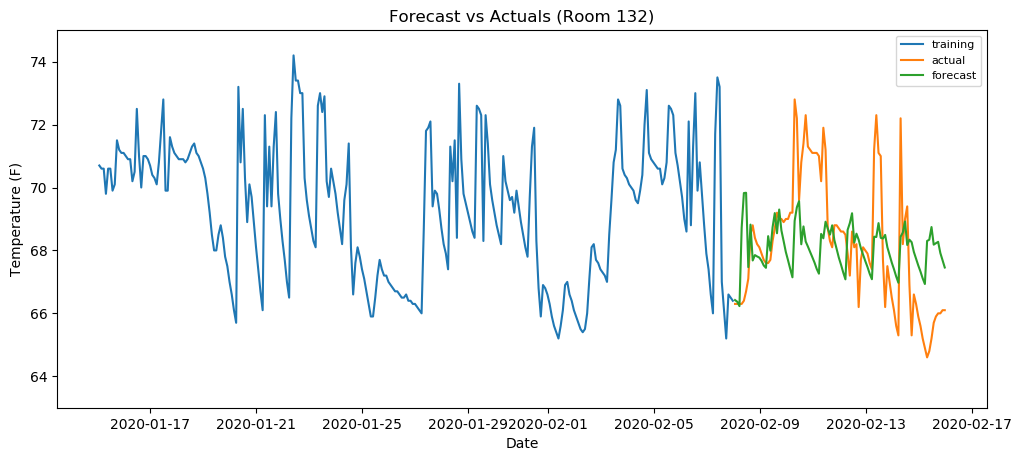

In [168]:
# make your forecasts
forecasts = model.predict(96)  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(ts.index[:288],train.values, label='training')
plt.plot(ts.index[288:],test.values, label='actual')
plt.plot(ts.index[288:],forecasts, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 132)')
plt.legend(loc='best', fontsize=8)
plt.ylim(63,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

In [85]:
print('RMSE: %.4f'% np.sqrt(sum((test.values-forecasts)**2)/len(forecasts)))

RMSE: 1.9399


## 2nd approach

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


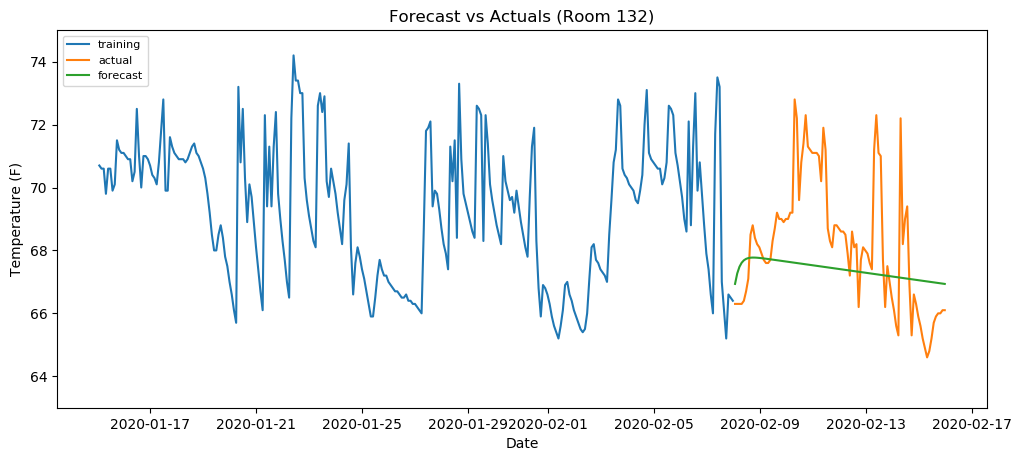

In [160]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(96, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 132)')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.legend(loc='upper left', fontsize=8)

plt.ylim(63,75)
plt.show()

In [161]:
print('RMSE: %.4f'% np.sqrt(sum((test.values-fc_series)**2)/len(fc_series)))

RMSE: 2.0781


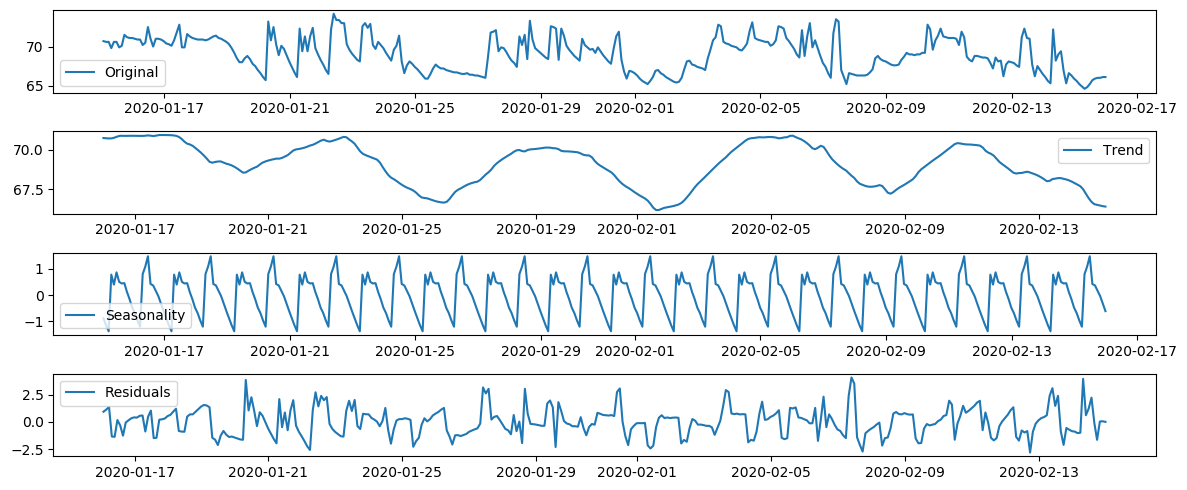

In [167]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,5), dpi=100)
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 3rd approach

In [131]:
# ts_log = np.log(ts)
# plt.plot(ts_log)

In [153]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(6).mean()
    rolstd = timeseries.rolling(6).std()

    #Plot rolling statistics:
    plt.figure(figsize=(12,5), dpi=100)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('dT (F)')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

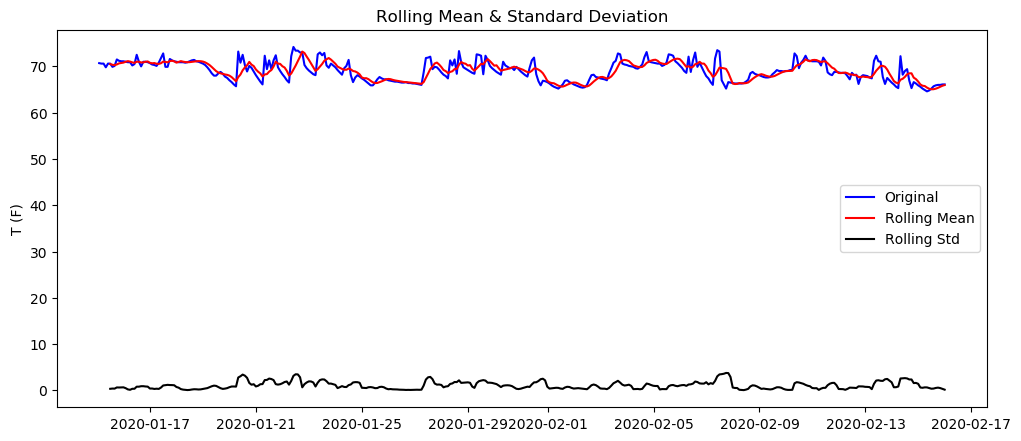

Results of Dickey-Fuller Test:
Test Statistic                  -2.611693
p-value                          0.090605
#Lags Used                      12.000000
Number of Observations Used    371.000000
Critical Value (1%)             -3.448100
Critical Value (5%)             -2.869362
Critical Value (10%)            -2.570937
dtype: float64


In [152]:
test_stationarity(ts)

In [90]:
# moving_avg = ts_log.rolling(6).mean()
# plt.plot(ts_log)
# plt.plot(moving_avg, color='red')

In [91]:
# ts_moving_avg_diff=ts_log-moving_avg
# ts_moving_avg_diff.dropna(inplace=True)
# ts_moving_avg_diff.head()

In [92]:
# test_stationarity(ts_moving_avg_diff)

In [93]:
# expwighted_avg = ts_log.ewm(halflife=3).mean()
# plt.plot(ts_log)
# plt.plot(expwighted_avg, color='red')

In [94]:
# ts_ewma_diff = ts_log - expwighted_avg
# test_stationarity(ts_ewma_diff)

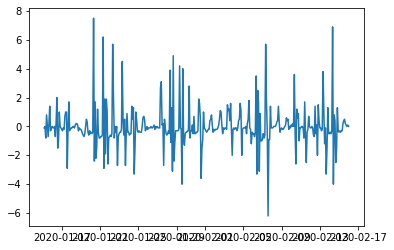

In [154]:
ts_diff=ts-ts.shift()
plt.plot(ts_diff)

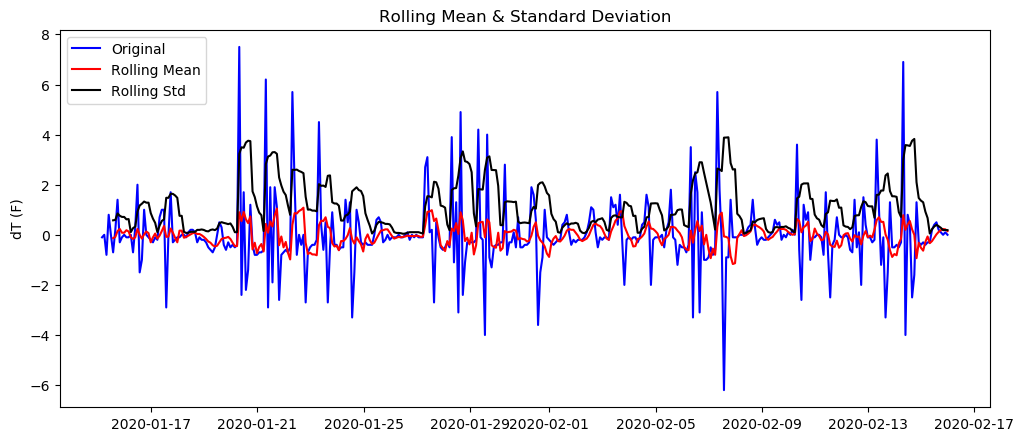

Results of Dickey-Fuller Test:
Test Statistic                -7.109460e+00
p-value                        3.973825e-10
#Lags Used                     1.100000e+01
Number of Observations Used    3.710000e+02
Critical Value (1%)           -3.448100e+00
Critical Value (5%)           -2.869362e+00
Critical Value (10%)          -2.570937e+00
dtype: float64


In [155]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

In [37]:
#ts_diff=ts_diff-ts_diff.shift()
#plt.plot(ts_diff)

In [38]:
#ts_diff.dropna(inplace=True)
#test_stationarity(ts_diff)

In [95]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition = seasonal_decompose(ts_log)

# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

# plt.subplot(411)
# plt.plot(ts_log, label='Original')
# plt.legend(loc='best')
# plt.subplot(412)
# plt.plot(trend, label='Trend')
# plt.legend(loc='best')
# plt.subplot(413)
# plt.plot(seasonal,label='Seasonality')
# plt.legend(loc='best')
# plt.subplot(414)
# plt.plot(residual, label='Residuals')
# plt.legend(loc='best')
# plt.tight_layout()

In [96]:
# ts_decompose = residual
# ts_decompose.dropna(inplace=True)
# test_stationarity(ts_decompose)

In [135]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [136]:
lag_acf = acf(ts_diff, nlags=6)
lag_pacf = pacf(ts_diff, nlags=6, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

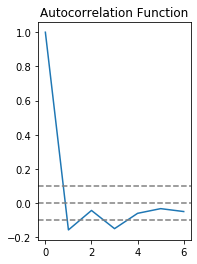

In [137]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

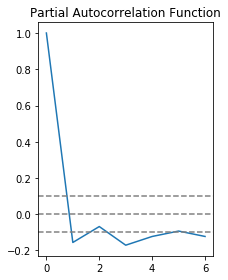

In [138]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [123]:
# model = ARIMA(ts_log, order=(1, 1, 0))  
# results_AR = model.fit(disp=-1)
# a=results_AR.fittedvalues
# a.index=ts_diff.index
# plt.plot(ts_diff)
# plt.plot(a, color='red')
# plt.title('RSS: %.4f'% sum((a-ts_diff)**2))

In [124]:
# model = ARIMA(ts_log, order=(0, 1, 1))  
# results_MA = model.fit(disp=-1)
# b=results_MA.fittedvalues
# b.index=ts_diff.index
# plt.plot(ts_diff)
# plt.plot(b, color='red')
# plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_diff)**2))

In [125]:
# model = ARIMA(ts_log, order=(1, 1, 1))  
# results_ARIMA = model.fit(disp=-1)  
# c=results_ARIMA.fittedvalues
# c.index=ts_diff.index
# plt.plot(ts_diff)
# plt.plot(c, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))

In [144]:
# residuals = pd.DataFrame(results_ARIMA.resid)
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

In [51]:
#results_ARIMA.plot_predict(dynamic=False)
#plt.show()

In [52]:
#AR forecast

In [97]:
# predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
# predictions_AR_diff.head()

In [98]:
# predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
# predictions_AR_diff_cumsum.head()

In [99]:
# predictions_AR_log = pd.Series(ts_log.ix[0], index=ts_log.index)
# predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
# predictions_AR_log.head()

In [100]:
# predictions_AR = np.exp(predictions_AR_log)
# plt.plot(ts,label='Actual')
# plt.plot(predictions_AR,label='AR_forecast')
# plt.legend(loc="upper right")
# plt.ylim(65,75)
# plt.xlabel('Date')
# plt.ylabel('Temperature (F)')

In [101]:
# print('RMSE: %.4f'% np.sqrt(sum((predictions_AR-ts)**2)/len(ts)))

In [58]:
#MA forecast

In [102]:
# predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
# predictions_MA_diff.head()

In [103]:
# predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
# predictions_MA_diff_cumsum.head()

In [104]:
# predictions_MA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
# predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
# predictions_MA_log.head()

In [105]:
# predictions_MA = np.exp(predictions_MA_log)
# plt.plot(ts,label='Actual')
# plt.plot(predictions_MA,label='MA_forecast')
# plt.legend(loc="upper right")
# plt.ylim(65,75)
# plt.xlabel('Date')
# plt.ylabel('Temperature (F)')

In [106]:
# print('RMSE: %.4f'% np.sqrt(sum((predictions_MA-ts)**2)/len(ts)))

In [64]:
#ARIMA forecast

In [126]:
# predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# predictions_ARIMA_diff.head()

In [127]:
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# predictions_ARIMA_diff_cumsum.head()

In [128]:
# predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
# predictions_ARIMA_log.head()

In [129]:
# predictions_ARIMA = np.exp(predictions_ARIMA_log)
# plt.plot(ts,label='Actual')
# plt.plot(predictions_ARIMA,label='ARIMA_forecast')
# plt.legend(loc="upper right")
# plt.ylim(57,75)
# plt.xlabel('Date')
# plt.ylabel('Temperature (F)')

In [130]:
# print('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))